In [53]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [54]:
# 设置GPU设备
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [55]:
# 一些可视化的函数
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [56]:
# 加载模型
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

图像数组的维度为: (2048, 2048, 3)


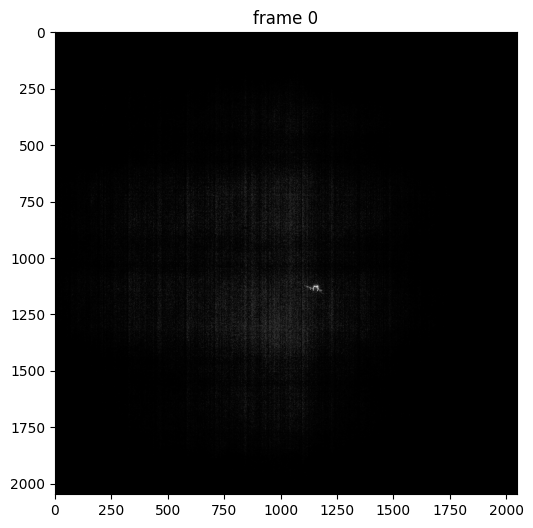

In [57]:
# 加载数据
video_dir = "./videos/ab_enhance_rename"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", ".png"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# cv2可视化第一帧图像
frame_idx = 0
image = cv2.imread(os.path.join(video_dir, frame_names[1]))
print("图像数组的维度为:", image.shape)
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

frame loading (JPEG): 100%|██████████| 69/69 [00:02<00:00, 25.91it/s]


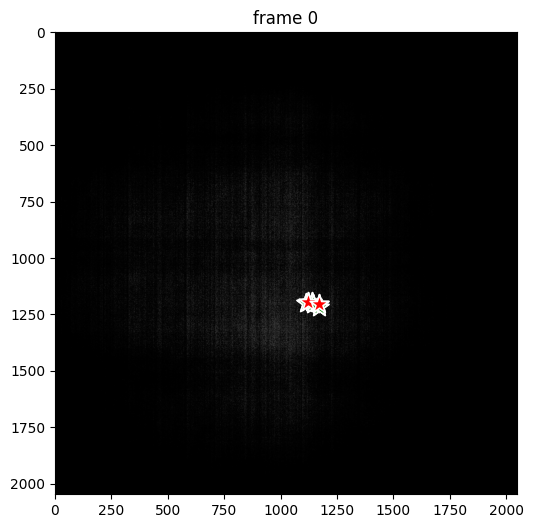

In [58]:
# 初始化推理
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

# 标注第一帧
ann_frame_idx = 0  # the frame index we interact with
 # give a unique id to each object we interact with (it can be any integers)
"""
0 主体
1 左帆板
2 右帆板
"""
prompts = {}  # hold all the clicks we add for visualization

# 整体正点
ann_obj_id = 0 
points = np.array([[1112, 1198], [1139, 1194], [1169, 1218],[1142, 1205], [1121, 1194], [1170, 1206]], dtype=np.float32)
labels = np.array([1, 1, 1, 1, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

"""
# 主体正负点
ann_obj_id = 0 
points = np.array([[440, 620], [380, 630], [480, 610]], dtype=np.float32)
labels = np.array([1, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# 左帆板正负点
ann_obj_id = 1 
points = np.array([[380, 630], [440, 620]], dtype=np.float32)
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# 右帆板正负点
ann_obj_id = 2 
points = np.array([[480, 610], [440, 620]], dtype=np.float32)
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
"""

# cv2可视化第一帧图像和标注
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
image = cv2.imread(os.path.join(video_dir, frame_names[ann_frame_idx]))
plt.imshow(image)
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [59]:
# 在整个视频帧进行推理
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 69/69 [00:59<00:00,  1.15it/s]


In [22]:
# 保存mask结果
def save_white_mask(mask, filename):
    # 获取掩膜的高度和宽度
    h, w = mask.shape[-2:]

    # 创建一个单通道的掩膜图像，值为0或255
    white_mask = np.zeros((h, w), dtype=np.uint8)  # 初始化为全黑
    # 如果mask是3维，取最后一个维度的最大值
    if mask.ndim == 3:
        mask = np.max(mask, axis=0)  # 合并到2维
    white_mask[mask > 0] = 255  # 将掩膜区域设置为白色

    # 保存为单通道图像
    cv2.imwrite(filename, white_mask)

# 保存mask路径
save_dir = "./results"

for out_frame_idx in range(0, len(frame_names), 1):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # 可视化并保存图像
        print(frame_names[out_frame_idx])
        save_white_mask(out_mask, os.path.join(save_dir, frame_names[out_frame_idx]))

00001.jpg
00002.jpg
00003.jpg
00004.jpg
00005.jpg
00006.jpg
00007.jpg
00008.jpg
00009.jpg
00010.jpg
00011.jpg
00012.jpg
00013.jpg
00014.jpg
00015.jpg
00016.jpg
00017.jpg
00018.jpg
00019.jpg
00020.jpg
00021.jpg
00022.jpg
00023.jpg
00024.jpg
00025.jpg
00026.jpg
00027.jpg
00028.jpg
00029.jpg
00030.jpg
00031.jpg
00032.jpg
00033.jpg
00034.jpg
00035.jpg
00036.jpg
00037.jpg
00038.jpg
00039.jpg
00040.jpg
00041.jpg
00042.jpg
00043.jpg
00044.jpg
00045.jpg
00046.jpg
00047.jpg
00048.jpg
00049.jpg
00050.jpg
00051.jpg
00052.jpg
00053.jpg
00054.jpg
00055.jpg
00056.jpg
00057.jpg
00058.jpg
00059.jpg
00060.jpg
00061.jpg
00062.jpg
00063.jpg
00064.jpg
00065.jpg
00066.jpg
00067.jpg
00068.jpg
00069.jpg


In [21]:
# 可视化并保存mask与图像结果
"""
vis_frame_stride = 1 # 间隔多少帧可视化一次
plt.close("all")
for out_frame_idx in range(0, len(frame_names), 1):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(cv2.imread(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # 可视化并保存图像
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        # 本地保存图像
        save_dir = "./results"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, frame_names[out_frame_idx])
        plt.savefig(save_path, dpi=300)
"""

SyntaxError: incomplete input (3659401953.py, line 2)

In [60]:
# 可视化并保存bbox与图像结果
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 绘制并显示 BBox
def show_bbox(out_mask, obj_id, ax, color="yellow", linewidth=2):
    """
    根据 mask 计算 bounding box (bbox) 并在图像上绘制
    """
    # 确保 mask 是二维
    if len(out_mask.shape) > 2:
        out_mask = np.squeeze(out_mask)
    out_mask = (out_mask > 0).astype(np.uint8)  # 二值化

    # 找到 mask 的非零区域
    y_indices, x_indices = out_mask.nonzero()
    if len(y_indices) == 0 or len(x_indices) == 0:
        return  # 如果 mask 是空的，直接跳过

    # 计算 bbox 的左上角和右下角坐标
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()

    # 绘制 bbox
    rect = plt.Rectangle(
        (x_min, y_min),  # 左上角
        x_max - x_min,   # 宽度
        y_max - y_min,   # 高度
        linewidth=linewidth,
        edgecolor=color,
        facecolor="none",
        label=f"ID {obj_id}"
    )
    ax.add_patch(rect)

# 保存图像和 BBox 的主逻辑
vis_frame_stride = 1  # 间隔多少帧进行处理
plt.close("all")

# 保存路径
save_dir = "./results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # 创建 figure
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis("off")  # 移除坐标轴

    # 读取当前帧图像
    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为 RGB 格式
    ax.imshow(image)

    # 遍历每个对象，绘制 BBox 并保存 mask
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # 绘制 BBox
        show_bbox(out_mask, out_obj_id, ax, color="yellow", linewidth=1)

    # 保存图像加 BBox 的可视化结果
    bbox_save_path = os.path.join(save_dir, f"{frame_names[out_frame_idx]}_bbox.png")
    plt.savefig(bbox_save_path, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close(fig)